# EfficientNetB4 for Fire Detection

In this notebook, we will test a DNN for fire detection using EfficientNet B4 as backbone network; both exploiting it as frozen network on top of which we will train a MLP classifier, and trying to unfreeze and finetune some layer.

EfficientNet was introduced by *Mingxing Tan and Quoc V. Le* in ***EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks***, and it consists on a state-of-the-art architecture able to reach high accuracy value with a limited amount of computation. 

The low number of parameters is a crucial feature for our application, for which we aim to detect fires at **real-time**, so we will need fast prediction capabilities. 

There exists 8 versions of EfficientNet (B0 to B7), that differ each other for the **scaling factor** of the network: higher scaling factor means (usually) more accuracy but also a more complex network. We selected B4 since, looking at the results furnished by the original paper, we thought to be the best tradeoff between good prediction power and high throughput. We will also try EfficientNet B0, because it has natively been projected to work with 224x224 images, which is exactly the resolution of the dataset at our disposal.


# Dataset preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/Shareddrives/SEAI Project/Dataset/trainingSet.zip" 

In [ ]:
BATCH_SIZE = 64
IMAGE_HEIGHT = 254
IMAGE_WIDTH = 254
SEED = 42
NUM_CLASSES = 2

In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from numpy.random import seed
seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# import the DNN_model class
%run '/content/drive/Shareddrives/SEAI Project/Notebooks/Model_class.ipynb'

In [ ]:
fpath = "content/training"

In [ ]:
training_set = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=True,
                                       seed=SEED,
                                       validation_split=0.2,
                                       subset='training',
                                       )

validation_set = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=True,
                                       seed=SEED,
                                       validation_split=0.2,
                                       subset='validation',
                                       )

Found 2968 files belonging to 2 classes.
Using 2375 files for training.
Found 2968 files belonging to 2 classes.
Using 593 files for validation.


In [ ]:
!unzip -q "/content/drive/Shareddrives/SEAI Project/Dataset/Test.zip" 

In [ ]:
test_set = image_dataset_from_directory("/content/Test",
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                       shuffle=False,
                                       )

Found 8617 files belonging to 2 classes.


# EfficientNet + MLP

## model definition

In [ ]:
input_tensor = Input(shape=(254, 254, 3))

base_model = EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

## model representation, training and results

In [ ]:
efficientnet_FE_model = DNN_model(model, name = "EfficientNetB4_FE")  #FE stands for Feature Extraction
efficientnet_FE_model.summary()
efficientnet_FE_model.plot_model()     #generates a jpeg file with model structure

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 254, 254, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 254, 254, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
efficientnet_FE_model.compile_and_fit(training_set, validation_set, epochs=20, patience=5)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9309
Epoch 1: val_loss improved from inf to 0.13450, saving model to /content/drive/Shareddrives/SEAI Project/Models/EfficientNetB4_FE.h5
38/38 [==============================] - 73s 1s/step - loss: 0.1772 - accuracy: 0.9309 - val_loss: 0.1345 - val_accuracy: 0.9562
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9768
Epoch 2: val_loss improved from 0.13450 to 0.13075, saving model to /content/drive/Shareddrives/SEAI Project/Models/EfficientNetB4_FE.h5
38/38 [==============================] - 40s 1s/step - loss: 0.0652 - accuracy: 0.9768 - val_loss: 0.1308 - val_accuracy: 0.9528
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9811
Epoch 3: val_loss improved from 0.13075 to 0.08304, saving model to /content/drive/Shareddrives/SEAI Project/Models/EfficientNetB4_FE.h5
38/38 [==============================] - 40s 1s/step 

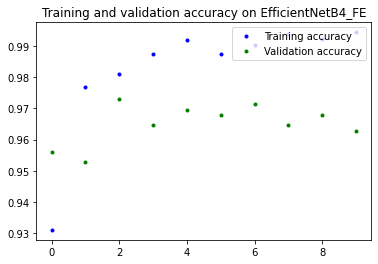

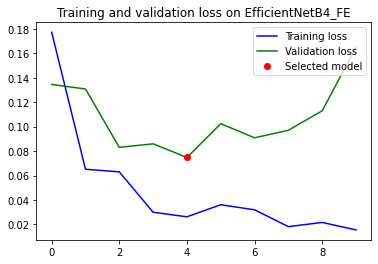

Lowest validation loss has been reached at epoch 5 with validation accuracy of 0.970


In [ ]:
efficientnet_FE_model.plot_accuracy()

In [ ]:
efficientnet_FE_model.load_best_model()
efficientnet_FE_model.evaluate(test_set)

135/135 [==============================] - 101s 748ms/step - loss: 1.4003 - accuracy: 0.6143
Test accuracy: 0.614, test loss: 1.400


# EfficientNet + smaller MLP


## model definition

In [ ]:
input_tensor = Input(shape=(254, 254, 3))

base_model = EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

## model representation, training and results

In [ ]:
smaller_efficientnet_FE_model = DNN_model(model, name = "Smaller_EfficientNetB4_FE") 
smaller_efficientnet_FE_model.summary()
smaller_efficientnet_FE_model.plot_model()     #generates a jpeg file with model structure

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 254, 254, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 254, 254, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
smaller_efficientnet_FE_model.compile_and_fit(training_set, validation_set, epochs=20, patience=5)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9322
Epoch 1: val_loss improved from inf to 0.08066, saving model to /content/drive/Shareddrives/SEAI Project/Models/Smaller_EfficientNetB4_FE.h5
38/38 [==============================] - 60s 1s/step - loss: 0.1748 - accuracy: 0.9322 - val_loss: 0.0807 - val_accuracy: 0.9696
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9781
Epoch 2: val_loss improved from 0.08066 to 0.07401, saving model to /content/drive/Shareddrives/SEAI Project/Models/Smaller_EfficientNetB4_FE.h5
38/38 [==============================] - 40s 1s/step - loss: 0.0664 - accuracy: 0.9781 - val_loss: 0.0740 - val_accuracy: 0.9713
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9832
Epoch 3: val_loss did not improve from 0.07401
38/38 [==============================] - 38s 968ms/step - loss: 0.0481 - accuracy: 0.9832 - val_loss: 0.0947 - val_accuracy: 0.

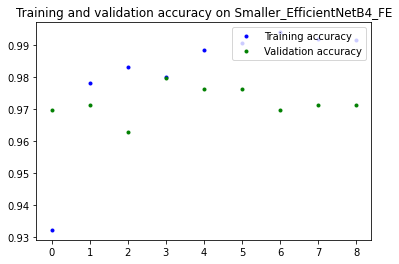

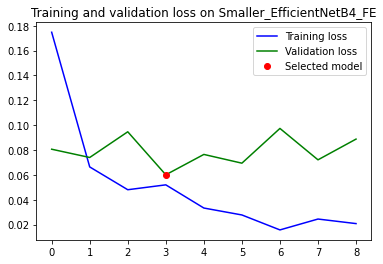

Lowest validation loss has been reached at epoch 4 with validation accuracy of 0.980


In [ ]:
smaller_efficientnet_FE_model.plot_accuracy()

In [ ]:
smaller_efficientnet_FE_model.load_best_model()
smaller_efficientnet_FE_model.evaluate(test_set)

135/135 [==============================] - 104s 743ms/step - loss: 0.9773 - accuracy: 0.6234
Test accuracy: 0.623, test loss: 0.977


# FineTuning 1 EfficientNet block


## model definition

In [ ]:
#loads previous model, which has already been trained
pretrained_model_class = DNN_model(None, "Smaller_EfficientNetB4_FE") 
pretrained_model_class.load_best_model() 

#unfreezes some layers and creates a new class
model = pretrained_model_class.unfreeze_layers("block7a_expand_conv") 
efficientnet_FT1_model = DNN_model(model, name = "EfficientNetB4_FT1") 

## model representation, training and results

In [ ]:
efficientnet_FT1_model.summary()
efficientnet_FT1_model.plot_model()     #generates a jpeg file with model structure

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 254, 254, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 254, 254, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
efficientnet_FT1_model.compile_and_fit(training_set, validation_set, epochs=20, patience=5, learning_rate=1e-4)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9869
Epoch 1: val_loss improved from inf to 0.06912, saving model to /content/drive/Shareddrives/SEAI Project/Models/EfficientNetB4_FT1.h5
38/38 [==============================] - 78s 1s/step - loss: 0.0328 - accuracy: 0.9869 - val_loss: 0.0691 - val_accuracy: 0.9730
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9937
Epoch 2: val_loss did not improve from 0.06912
38/38 [==============================] - 42s 1s/step - loss: 0.0238 - accuracy: 0.9937 - val_loss: 0.0701 - val_accuracy: 0.9764
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9937
Epoch 3: val_loss did not improve from 0.06912
38/38 [==============================] - 42s 1s/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0752 - val_accuracy: 0.9747
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9987
Epoch 4: 

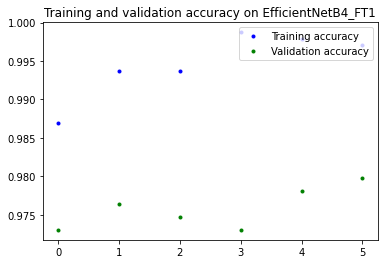

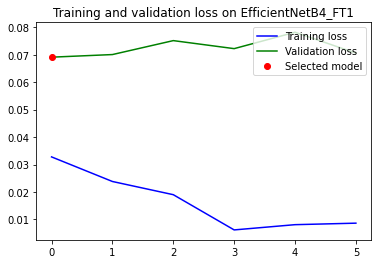

Lowest validation loss has been reached at epoch 1 with validation accuracy of 0.973


In [ ]:
efficientnet_FT1_model.plot_accuracy()

In [ ]:
efficientnet_FT1_model.load_best_model()
efficientnet_FT1_model.evaluate(test_set)

135/135 [==============================] - 108s 775ms/step - loss: 1.1786 - accuracy: 0.6261
Test accuracy: 0.626, test loss: 1.179


# Introducing class weights


In [ ]:
n_images_with_fire = len(os.listdir(os.path.join(fpath, "Fire")))
n_images_without_fire = len(os.listdir(os.path.join(fpath, "No_Fire")))
total_images = n_images_with_fire + n_images_without_fire

class_weights ={0: total_images/(NUM_CLASSES*n_images_with_fire), 1: total_images/(NUM_CLASSES*n_images_without_fire)}
print(class_weights)

{0: 0.8587962962962963, 1: 1.196774193548387}


## model definition

In [ ]:
input_tensor = Input(shape=(254, 254, 3))

base_model = EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

71696384/71686520 [==============================] - 1s 0us/step


## model representation, training and results

In [ ]:
weihgted_efficientnet_FE_model = DNN_model(model, name = "Weihgted_EfficientNetB4_FE") 
weihgted_efficientnet_FE_model.summary()
weihgted_efficientnet_FE_model.plot_model()     #generates a jpeg file with model structure

In [ ]:
weihgted_efficientnet_FE_model.compile_and_fit(training_set, validation_set, epochs=20, patience=5, class_weights=class_weights)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9402
Epoch 1: val_loss improved from inf to 0.12109, saving model to /content/drive/Shareddrives/SEAI Project/Models/Weihgted_EfficientNetB4_FE.h5
38/38 [==============================] - 72s 1s/step - loss: 0.1766 - accuracy: 0.9402 - val_loss: 0.1211 - val_accuracy: 0.9545
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9693
Epoch 2: val_loss improved from 0.12109 to 0.10990, saving model to /content/drive/Shareddrives/SEAI Project/Models/Weihgted_EfficientNetB4_FE.h5
38/38 [==============================] - 40s 1s/step - loss: 0.0785 - accuracy: 0.9693 - val_loss: 0.1099 - val_accuracy: 0.9595
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9773
Epoch 3: val_loss improved from 0.10990 to 0.06547, saving model to /content/drive/Shareddrives/SEAI Project/Models/Weihgted_EfficientNetB4_FE.h5
38/38 [===================

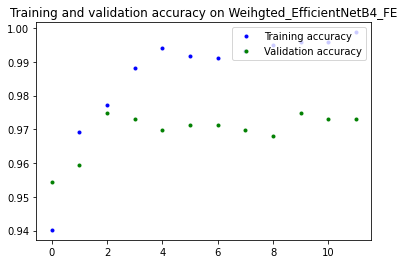

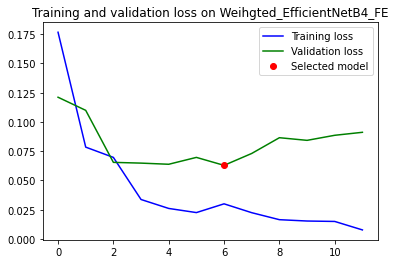

Lowest validation loss has been reached at epoch 7 with validation accuracy of 0.971


In [ ]:
weihgted_efficientnet_FE_model.plot_accuracy()

In [ ]:
weihgted_efficientnet_FE_model.load_best_model()
weihgted_efficientnet_FE_model.evaluate(test_set)

135/135 [==============================] - 109s 781ms/step - loss: 0.8972 - accuracy: 0.6425
Test accuracy: 0.642, test loss: 0.897


135/135 [==============================] - 105s 757ms/step


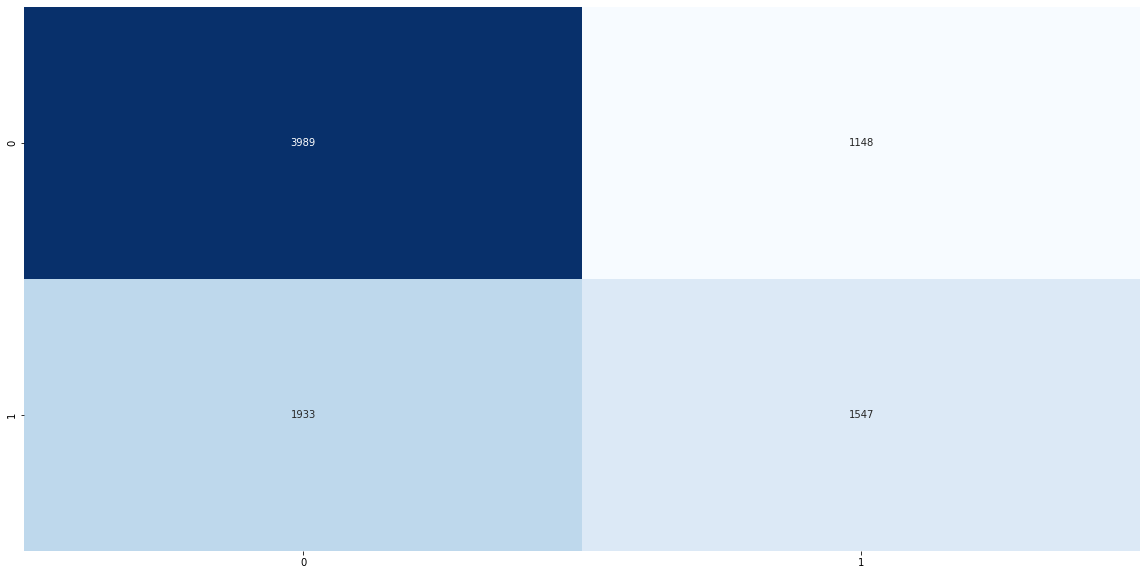

In [ ]:
weihgted_efficientnet_FE_model.plot_confusion_matrix(test_set)